In [14]:
import pandas as pd
from darts import TimeSeries

from DBIO import YouBikeDataManager
db_path = "../youbike_data.db"
datamanager = YouBikeDataManager(db_path)
sno = '500101028'
df = datamanager.load_and_preprocess_station(sno)
df.head()
df = df.reset_index()
df["mday"] = pd.to_datetime(df["mday"])

In [15]:
df.head()

,mday,available_rent_bikes,available_return_bikes,capacity,demand
0,2024-11-18 12:00:00,12,8,20,0
1,2024-11-18 13:00:00,12,8,20,0
2,2024-11-18 14:00:00,14,6,20,-2
3,2024-11-18 15:00:00,11,9,20,3
4,2024-11-18 16:00:00,10,10,20,1


In [16]:
df.dtypes

mday                      datetime64[ns]
available_rent_bikes               int64
available_return_bikes             int64
capacity                           int64
demand                             int64
dtype: object

In [17]:
print(series.time_index)


DatetimeIndex(['2024-11-18 12:00:00', '2024-11-18 13:00:00',
               '2024-11-18 14:00:00', '2024-11-18 15:00:00',
               '2024-11-18 16:00:00', '2024-11-18 17:00:00',
               '2024-11-18 18:00:00', '2024-11-18 19:00:00',
               '2024-11-18 20:00:00', '2024-11-18 21:00:00',
               ...
               '2025-01-24 06:00:00', '2025-01-24 07:00:00',
               '2025-01-24 08:00:00', '2025-01-24 09:00:00',
               '2025-01-24 10:00:00', '2025-01-24 11:00:00',
               '2025-01-24 12:00:00', '2025-01-24 13:00:00',
               '2025-01-24 14:00:00', '2025-01-24 15:00:00'],
              dtype='datetime64[ns]', name='mday', length=1612, freq='h')


In [19]:
# Read a pandas DataFrame
# df = pd.read_csv("AirPassengers.csv", delimiter=",")

# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(df, "mday", "demand", freq="H")  # Use appropriate frequency

# Set aside the last 36 months as a validation series
val_set_size = int(len(df) * 0.05)  # Convert to integer
train, val = series[:-val_set_size], series[-val_set_size:]

/home/mojoee/Development/YouBike/YouBikeLive/venv/lib/python3.10/site-packages/darts/timeseries.py:4866: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_time_index = resampled_time_index.asfreq(freq)


In [25]:
from darts.models import ExponentialSmoothing, AutoARIMA

model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val), num_samples=1000)

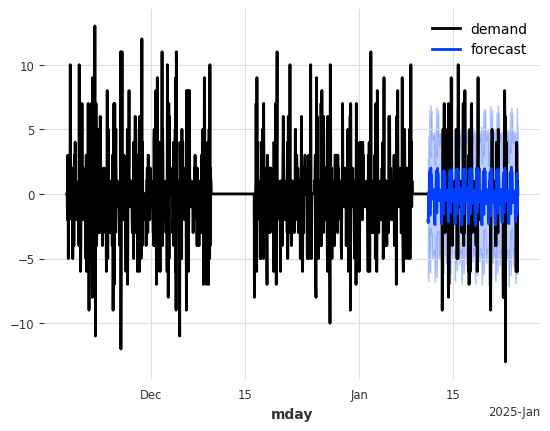

In [26]:
import matplotlib.pyplot as plt

series.plot()
prediction.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()

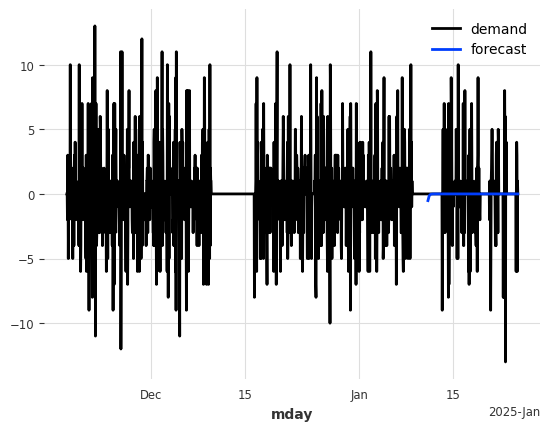

In [28]:
model = AutoARIMA()
model.fit(train)
prediction = model.predict(len(val))

series.plot()
prediction.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [31]:
# backtesting

from darts.models import Prophet

models = [ExponentialSmoothing(), Prophet(), AutoARIMA()]

backtests = [model.historical_forecasts(series,
                            start=.8,
                            forecast_horizon=3,
                            retrain=True)
             for model in models]

KeyboardInterrupt: 

In [32]:
import pandas as pd
from darts import TimeSeries
from darts.models import ExponentialSmoothing, Prophet, AutoARIMA
from darts.metrics import smape
import matplotlib.pyplot as plt

# Assuming `df` is your DataFrame and 'mday' is the datetime column
series = TimeSeries.from_dataframe(df, 'mday', 'available_rent_bikes')

# Split data into train, validation, and test sets
train_val, test = series.split_before(0.8)
train, val = train_val.split_before(0.8)

# Define models
models = [ExponentialSmoothing(), Prophet(), AutoARIMA()]

# Fit models and evaluate on validation set
backtests = []
for model in models:
    model.fit(train)
    val_forecast = model.predict(len(val))
    backtests.append(val_forecast)
    print(f"{model.__class__.__name__} SMAPE: {smape(val, val_forecast)}")

# Plot the results
series.plot(label='data')
for i, m in enumerate(models):
    err = smape(backtests[i], series)
    backtests[i].plot(lw=3, label='{}, SMAPE={:.2f}%'.format(m.__class__.__name__, err))

plt.title('Backtests with 3-months forecast horizon')
plt.legend()
plt.show()

ValueError: `actual_series` must be strictly positive to compute the MAPE.


ValueError: `actual_series` must be strictly positive to compute the MAPE.

In [ ]:
from darts.metrics import mape

series.plot(label='data')
for i, m in enumerate(models):
    err = mape(backtests[i], series)
    backtests[i].plot(lw=3, label='{}, MAPE={:.2f}%'.format(m, err))

plt.title('Backtests with 3-months forecast horizon')
plt.legend()


In [5]:
from darts.datasets import ETTh2Dataset

series = ETTh2Dataset().load()[:10000][["MUFL", "LULL"]]
train, val = series.split_before(0.6)

In [6]:
from darts.ad import KMeansScorer

scorer = KMeansScorer(k=2, window=5)
scorer.fit(train)
anom_score = scorer.score(val)

In [7]:
from darts.ad import QuantileDetector

detector = QuantileDetector(high_quantile=0.99)
detector.fit(scorer.score(train))
binary_anom = detector.detect(anom_score)

<Axes: xlabel='date'>

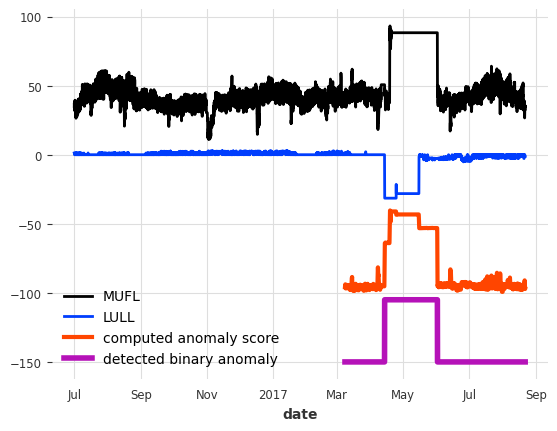

In [8]:
import matplotlib.pyplot as plt

series.plot()
(anom_score / 2. - 100).plot(label="computed anomaly score", c="orangered", lw=3)
(binary_anom * 45 - 150).plot(label="detected binary anomaly", lw=4)